In [38]:
from rllib.mdp import OptimalGoalPolicy
from rllib.shapeworld import GoalWorld
from sklearn.manifold import MDS
from itertools import combinations, product
import numpy as np
import pandas as pd
import random
from random import sample, Random
from math import log
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
from typing import Sequence, Hashable, TypeVar, Generic, Container, Tuple
import pickle
from collections import defaultdict, Counter, namedtuple
from tqdm import tqdm
from rllib.mdp import MarkovDecisionProcess
from scipy.special import logsumexp
from concurrent.futures import ProcessPoolExecutor
import concurrent

## Class definitions

In [9]:

# We want actions to be hashable so that we can use them as dictionary keys for Q-learning later
Action = TypeVar('Action', bound=Hashable)
Shape = namedtuple('Shape',['sides', 'shade', 'texture'])
State = TypeVar('State', bound=Hashable)
Likelihood = TypeVar('Likelihood', float, int)

class GoalSelectionPolicy(Generic[State, Action]):
    def __init__(self, mdp: MarkovDecisionProcess[State, Action]):
        '''Initialize the policy with the MDP.'''
        self.mdp = mdp
        self.state_space = mdp.state_space

    def sample_action(self, rng : Random = random) -> tuple[Action, Likelihood]:
        '''Uses some policy to select which goal to select.'''
        raise NotImplementedError

    def reset(self):
        raise NotImplementedError

class OptimalGoalPolicy(GoalSelectionPolicy[State, Action]):
    '''Takes the optimal value function computed from value iteration to select goals.'''

    def __init__(self, mdp: MarkovDecisionProcess[State, Action], value_function: dict[State, float]):
        super().__init__(mdp)
        # we will use the value function from value iteration to select the goal
        self.value_function = value_function
        self.mds = None # multidimensional scaling

    def sample_action(self, rng: random.Random = random) -> tuple[State, float]:
        '''Use softmax to sample a goal state based on the value function.'''
        # Assuming 'actions' here are actually states for goal selection
        states = list(self.value_function.keys())
        state_values = np.array([self.value_function[state] for state in states])

        # Compute softmax probabilities
        exp_values = np.exp(state_values - np.max(state_values))  # for numerical stability
        probabilities = exp_values / np.sum(exp_values)

        # Sample a state based on these probabilities
        selected_state = rng.choices(states, weights=probabilities)[0]

        # Calculate the negative log likelihood of the selected state
        nll = -np.log(probabilities[states.index(selected_state)])

        return (selected_state, nll)
    
    def calc_neg_log_lik(self, state: State) -> float:
        '''Calculate the negative log likelihood of selecting a particular state.

        Parameters:
        state (State): The state for which to calculate the negative log likelihood.

        Returns:
        float: The negative log likelihood of selecting the given state.
        '''
        state_values = np.array([self.value_function[s] for s in self.state_space])
        exp_values = np.exp(state_values - np.max(state_values))
        probabilities = exp_values / np.sum(exp_values)
        return -np.log(probabilities[self.state_space.index(state)])
    
    def calc_neg_log_likelihood_all(self) -> dict[State, float]:
        '''Calculate the log likelihood of all states in the state space.'''
        # get all the values for the states and convert them to probabilities
        state_values = np.array([self.value_function[state] for state in self.state_space])
        exp_values = np.exp(state_values - np.max(state_values))
        probabilities = exp_values / np.sum(exp_values)
        assert probabilities.sum() == 1
        # print(f"Length of probabilities: {len(probabilities)}")
        neg_log_likelihoods = {s: -np.log(probabilities[self.state_space.index(s)]) for s in self.state_space}
        return neg_log_likelihoods
    
    def calc_neg_log_likelihood_all_df(self) -> pd.DataFrame:
        '''Return log lik as a dataframe.'''
        neg_log_likelihood = self.calc_neg_log_likelihood_all()
        return pd.DataFrame(neg_log_likelihood.items(), columns=['State', 'Negative Log Lik'])
    
    def _load_value_functions_all(self, directory):
        """
        Load all value function files from the specified directory.
        
        Note, this is not the same as the value function for choosing goals. 
        These are the results of value iteration for separate goal state.
        This is intended to be used for calculated a distance matrix between states.
        """
        print('Loading value functions from directory:', directory)
        value_functions = {}
        for filename in tqdm(os.listdir(directory), desc='Loading files'):
            if filename.endswith('.pkl'):
                filepath = os.path.join(directory, filename)
                with open(filepath, 'rb') as file:
                    value_function, goal_state = pd.read_pickle(file)
                    adjusted_value_function = {state: value - self.mdp.GOAL_REWARD for state, value in value_function.items()}
                    value_functions[goal_state] = adjusted_value_function
        return value_functions

    def _calc_distance_matrix(self) -> np.ndarray:
        '''Calculate the distance matrix between all states in the state space.'''

        val_funs = self._load_value_functions_all('value-iteration-results')

        # Extract all unique states from the keys of the value functions
        print('Sorting states...')
        states = list(set.union(*[set(vf.keys()) for vf in val_funs.values()]))
        states.sort()  # Ensure consistent order
        num_states = len(states)

        # Initialize the distance matrix with infinity
        distance_matrix = np.full((num_states, num_states), np.inf)

        # Fill in the distance matrix
        for i, state_i in tqdm(enumerate(states), total=len(states), desc="Computing distance matrix"):
            for j, state_j in enumerate(states):
                if state_i in val_funs and state_j in val_funs[state_i]:
                    value = val_funs[state_i][state_j]
                    # larger negative means further from goal, thus abs()
                    distance_matrix[i, j] = abs(value) if value != 0 else np.inf
                    # Goals states have a distance of 0
                    if state_j == state_i:
                        distance_matrix[i, j] = 0

        # Our distance is not symmetric since there are some state transitions that are asymetric
        for i in tqdm(range(num_states), desc="Ensuring symmetry"):
            for j in range(i+1, num_states):  # Only iterate over the upper triangle, excluding the diagonal
                # Take the minimum distance as our measure of similarity
                min_distance = min(abs(distance_matrix[i, j]), abs(distance_matrix[j, i]))
                # Update both entries to ensure symmetry
                distance_matrix[i, j] = distance_matrix[j, i] = min_distance
        return distance_matrix

    def calc_multi_dimensional_scaling(self) -> np.ndarray:
        # check to see if MDS already calculated
        if os.path.exists('mds_value_iteration.pkl'):
            with open('mds_value_iteration.pkl', 'rb') as file:
                self.mds = pickle.load(file)
                return self.mds
        
        distance_matrix = self._calc_distance_matrix()

        # Apply MDS
        print('Applying Multi-Dimensional Scaling...')
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
        coords = mds.fit_transform(distance_matrix)

        self.mds = coords
        # Save the MDS coordinates
        with open('mds_value_iteration.pkl', 'wb') as file:
            pickle.dump(coords, file)

    def plot_state_space(self):
        '''Plot the state space in 2D using MDS.'''
        if self.mds is None:
            self.calc_multi_dimensional_scaling()

        plt.figure(figsize=(10, 8))
        plt.scatter(self.mds[:, 0], self.mds[:, 1], marker='o')
        for i, coord in enumerate(self.mds):
            plt.text(coord[0], coord[1], str(i), color='red')
        plt.title('ShapeWorld Visualization')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.show()

    def plot_state_space_with_likelihood(self, is_dark=False, save=False, filename=None):
        '''Plot the state space in 2D using MDS with the negative log likelihood of each state.'''
        
        # Check to see if the mds has been calculated
        if self.mds is None:
            self.calc_multi_dimensional_scaling()

        # Calculate the negative log likelihood of each state
        neg_log_likelihoods = self.calc_neg_log_likelihood_all_df()


        # Set the font properties
        font_path = os.path.abspath('/System/Library/Fonts/HelveticaNeue.ttc')  # Replace with the path to your desired font file
        font_prop = fm.FontProperties(fname=font_path, size=14)

        # set defult style
        matplotlib.rcdefaults()
        plt.figure(figsize=(10, 8))
        
        # Sort the coordinates and likelihoods in descending order based on likelihoods
        sorted_indices = np.argsort(neg_log_likelihoods['Negative Log Lik'])[::-1]
        #print(sorted_indices)
        sorted_coords = self.mds[sorted_indices]
        # print(sorted_coords)
        sorted_likelihoods = np.array(neg_log_likelihoods['Negative Log Lik'])[sorted_indices]
        print(sorted_likelihoods)
        # Plot the points with greater likelihoods on top
        plt.scatter(sorted_coords[:, 0], sorted_coords[:, 1], c=sorted_likelihoods, cmap='plasma_r', marker='o', alpha=1, s=70)
        plt.title('ShapeWorld 2D Embedding by Distance: Optimal Planner', fontsize=15)
        plt.xlabel('Dimension 1', fontproperties=font_prop, fontsize=16)  # Set the font properties for x-axis label
        plt.ylabel('Dimension 2', fontproperties=font_prop, fontsize=16)  # Set the font properties for y-axis label
        plt.colorbar(label='Negative Log Lik')
        plt.grid(False)  # Remove gridlines

        plt.xticks([])  # Remove x-axis tick labels
        plt.yticks([])  # Remove y-axis tick labels
        plt.tight_layout()  # Adjust spacing
        plt.show()

        if save:
            plt.savefig(filename)

    def plot_state_space_with_other_model_likelihood_df(self, negloglik: pd.DataFrame, model_name, is_dark=False, save=False, filename=None):
        '''Plot the state space in 2D using MDS with the negative log likelihood from another model.'''

       # Check to see if the mds has been calculated
        if self.mds is None:
            self.calc_multi_dimensional_scaling()

        # Calculate the negative log likelihood of each state
        neg_log_likelihoods = negloglik

        # Set the font properties
        font_path = os.path.abspath('/System/Library/Fonts/HelveticaNeue.ttc')  # Replace with the path to your desired font file
        font_prop = fm.FontProperties(fname=font_path, size=14)

        # set deafult style
        matplotlib.rcdefaults()

        plt.figure(figsize=(10, 8))
        # Sort the coordinates and likelihoods in descending order based on likelihoods
        sorted_indices = np.argsort(neg_log_likelihoods['negloglik'])[::-1]
        #print(sorted_indices)
        sorted_coords = self.mds[sorted_indices]
        # print(sorted_coords)
        sorted_likelihoods = np.array(neg_log_likelihoods['negloglik'])[sorted_indices]
        print(sorted_likelihoods)
        # Plot the points with greater likelihoods on top
        plt.scatter(sorted_coords[:, 0], sorted_coords[:, 1], c=sorted_likelihoods, cmap='plasma_r', marker='o', alpha=1, s=70)
        plt.title('ShapeWorld 2D Embedding by Distance: Optimal Planner', fontsize=15)
        plt.xlabel('Dimension 1', fontproperties=font_prop, fontsize=16)  # Set the font properties for x-axis label
        plt.ylabel('Dimension 2', fontproperties=font_prop, fontsize=16)  # Set the font properties for y-axis label
        plt.colorbar(label='Negative Log Lik')
        plt.grid(False)  # Remove gridlines

        plt.xticks([])  # Remove x-axis tick labels
        plt.yticks([])  # Remove y-axis tick labels
        plt.tight_layout()  # Adjust spacing
        plt.show()

    def reset(self):
        pass

class ShapeWorld(MarkovDecisionProcess[State, Action]):
    GOAL = None
    GOAL_REWARD = 100 # we let this be zero because of averaging across Q-tables we do later
    STEP_COST = -1
    SHAPE_LIST = tuple(['circle','square','triangle'])
    SHADE_LIST = tuple(['low','medium','high'])
    TEXTURE_LIST = tuple(['striped','plain','dots'])
    SHAPE_TRANSITION_PROB = 0.8

    def __init__(self, goal : State, discount_rate):
        '''Runs the initialization of the ShapeWorld class.'''
        self.discount_rate = discount_rate
        self.GOAL = goal

        # set up shapeworld shape space
        shape_space : Sequence[Shape] = tuple(
            Shape(sides, shade, texture) 
                for (sides, shade, texture) 
                    in product(self.SHAPE_LIST,self.SHADE_LIST,self.TEXTURE_LIST)
        )
            
        # set up state space
        self.state_space : Sequence[State] = tuple(
            State(shape1, shape2, shape3) for(shape1, shape2, shape3) in product(shape_space, shape_space, shape_space)
        )

        # set up state action space
        self.action_space = tuple([a1r2, a1r3, a2r1, a2r3, a3r1, a3r2])
        self.state_action_space = tuple(product(self.state_space, self.action_space))

    def next_state_sample(
            self,
            s : State,
            a : Action,
            rng : random.Random = random
    ) -> State:
        '''
        Given a state and action, return a possible next state.
        '''
        # determine if recipient shape changes
        if rng.random() < self.SHAPE_TRANSITION_PROB:
            sides = s[a.actor].sides
        else:
            sides = s[a.recipient].sides
        
        # determine if the recipient shade changes
        shade = None

        if self._is_darker(s[a.actor].shade, s[a.recipient].shade):
            shade = self._get_darker_shade(s[a.recipient].shade)

        elif self._is_lighter(s[a.actor].shade, s[a.recipient].shade):
            shade = self._get_lighter_shade(s[a.recipient].shade)

        else:
            shade = s[a.recipient].shade

        # determine recipient texture change alternates deterministically
        if s[a.recipient].texture == 'plain':
            texture = 'striped'
        if s[a.recipient].texture == 'striped':
            texture = 'dots'
        if s[a.recipient].texture == 'dots':
            texture = 'plain'

        # instantiate next state
        new_state_list  = [s[0], s[1], s[2]]
        new_state_list[a.recipient] = Shape(sides, shade, texture)
        new_state = State(*new_state_list)

        return new_state

    def reward(self, s: State, a : Action, ns : State) -> float:
        reward = self.STEP_COST
        if self._is_goal(ns):
            reward += self.GOAL_REWARD
        return reward

    def is_absorbing(self, s: State) -> bool:
        '''
        Check to see if state is absorbing. 

        For this context, the goal state is our absorbing state, and the simulation should be terminated if reached.

        Returns:
            bool: Whether the state is an absorbing state or not.
        '''
        is_absorbing = np.nan
        if self.GOAL == s:
            is_absorbing = True
        else:
            is_absorbing = False
        
        return is_absorbing

    def get_possible_next_states(self, s: State, a: Action) -> Sequence[State]:
        """Return the possible next states given a state and action."""
        
        # either the recipient shape takes on parent shape or doesn't
        possible_sides = [s[a.actor].sides, s[a.recipient].sides]
        # recipient becomes lighter, darker, or same
        possible_shades = [
            s[a.recipient].shade,
            self._get_lighter_shade(s[a.recipient].shade),
            self._get_darker_shade(s[a.recipient].shade)]
        # texture always changes
        possible_texture = ['plain' if s[a.recipient].texture == 'striped' else 'striped']
        possible_states = set()

        # create all possible next states by replacing recipient state
        for side in possible_sides:
            for shade in possible_shades:
                for texture in possible_texture:
                    new_shape = Shape(side, shade, texture)
                    new_state_list = [s[0], s[1], s[2]] # shapes of current state
                    new_state_list[a.recipient] = new_shape
                    new_state = State(*new_state_list) # unpack new state list
                    possible_states.add(new_state) # using a set ensures uniqueness

        return list(possible_states)
    
    def transition_probability(self, s: State, a: Action, ns: State) -> float:
        """
        Return the transition probability from state s to state ns given action a.
        Only valid for valid possible next states. 
        """
        # determine if recipient shape changes
        if ns[a.recipient].sides != s[a.actor].sides:
            return 1 - self.SHAPE_TRANSITION_PROB
        else:
            # if the recipient shade changes, it's a the same probability as the shape transition
            if self._is_darker(s[a.actor].shade, s[a.recipient].shade) and ns[a.recipient].shade == self._get_darker_shade(s[a.recipient].shade):
                return self.SHAPE_TRANSITION_PROB
            elif self._is_lighter(s[a.actor].shade, s[a.recipient].shade) and ns[a.recipient].shade == self._get_lighter_shade(s[a.recipient].shade):
                return self.SHAPE_TRANSITION_PROB
            # if the shade doesn't change, the texture must change
            elif s[a.recipient].shade == ns[a.recipient].shade:
                # determine recipient texture change
                if s[a.recipient].texture == 'plain' and ns[a.recipient].texture == 'striped':
                    return self.SHAPE_TRANSITION_PROB
                elif s[a.recipient].texture == 'striped' and ns[a.recipient].texture == 'dots':
                    return self.SHAPE_TRANSITION_PROB
                elif s[a.recipient].texture == 'dots' and ns[a.recipient].texture == 'plain':
                    return self.SHAPE_TRANSITION_PROB
                # texture must always change
                elif s[a.recipient].texture == ns[a.recipient].texture:
                    return 0
            else:
                return 0

    def plot(self, ax=None):
        # TODO: I should implement some form of visualization to make sure that everything is working as expected.
        raise NotImplementedError

    def get_state_space(self) -> Sequence[State]:
        '''Return the state space.'''
        return self.state_space
    
    def get_actions(self, s : State) -> Sequence[Action]:
        '''Return the action space.'''
        return self.action_space

    # helper functions
    def _is_goal(self, ns : State):
        return self.GOAL == ns

    def _is_darker(self, shade1, shade2):
        return self.SHADE_LIST.index(shade1) > self.SHADE_LIST.index(shade2)
    
    def _is_lighter(self, shade1, shade2):
        return self.SHADE_LIST.index(shade1) < self.SHADE_LIST.index(shade2)
    
    def _get_darker_shade(self, shade):
        current_idx = self.SHADE_LIST.index(shade)
        # if shade cannot go lower
        if current_idx == len(self.SHADE_LIST) - 1:
            return shade
        else:
            return self.SHADE_LIST[current_idx + 1]
    
    def _get_lighter_shade(self, shade):
        current_idx = self.SHADE_LIST.index(shade)
        # if shade cannot go lower
        if current_idx - 1 < 0:
            return shade
        else:
            return self.SHADE_LIST[current_idx - 1]


# Optimal Policy

In [24]:
# Set up the goal space
State = namedtuple('State', ['shape1', 'shape2', 'shape3'])
#State = TypeVar('State', bound=Hashable)
goal_world = GoalWorld()

# Initialize optimal agent
with open('goal_value_function.pkl', 'rb') as file:
    # use saved results from value iteration
    value_function = pickle.load(file)
'''
# We changes the names of textures, so we need to update the value function
updated_value_function = {}

for state, value in value_function.items():
    # Unpack the shapes from the state
    shape1, shape2, shape3 = state.shape1, state.shape2, state.shape3
    
    # Update textures
    shape1_texture = 'striped' if shape1.texture == 'present' else 'plain'
    shape2_texture = 'striped' if shape2.texture == 'present' else 'plain'
    shape3_texture = 'striped' if shape3.texture == 'present' else 'plain'
    
    # Create new shapes with updated textures
    updated_shape1 = Shape(sides=shape1.sides, shade=shape1.shade, texture=shape1_texture)
    updated_shape2 = Shape(sides=shape2.sides, shade=shape2.shade, texture=shape2_texture)
    updated_shape3 = Shape(sides=shape3.sides, shade=shape3.shade, texture=shape3_texture)
    
    # Create a new state with updated shapes
    updated_state = State(shape1=updated_shape1, shape2=updated_shape2, shape3=updated_shape3)
    
    # Add the updated state to the temporary dictionary
    updated_value_function[updated_state] = value

# Replace the original value_function with the updated one
value_function = updated_value_function
'''
# create the optimal planner
optimal_planner = OptimalGoalPolicy(
    mdp=goal_world,
    value_function=value_function
)

# What are the best goals to set?
log_likelihood_df = optimal_planner.calc_neg_log_likelihood_all_df()
value_iteration_states_neg_log_lik = log_likelihood_df.sort_values(by='Negative Log Lik').reset_index(drop=True)




KeyError: State(shape1=Shape(sides='circle', shade='low', texture='striped'), shape2=Shape(sides='square', shade='high', texture='striped'), shape3=Shape(sides='circle', shade='high', texture='striped'))

In [25]:
#value_function
#value_function[optimal_planner.mdp.get_state_space()[0]]
optimal_planner.mdp.get_state_space()[0]

State(shape1=Shape(sides='circle', shade='low', texture='striped'), shape2=Shape(sides='circle', shade='low', texture='striped'), shape3=Shape(sides='circle', shade='low', texture='striped'))

In [26]:
value_function[optimal_planner.mdp.get_state_space()[0]]

8.592942235053302

In [28]:
state1 = State(shape1=Shape(sides='circle', shade='low', texture='striped'), shape2=Shape(sides='square', shade='high', texture='striped'), shape3=Shape(sides='circle', shade='high', texture='striped'))
value_function[state1]

8.592942235053302

In [29]:
key = State(
    shape1=Shape(sides='circle', shade='low', texture='striped'),
    shape2=Shape(sides='square', shade='high', texture='striped'),
    shape3=Shape(sides='circle', shade='high', texture='striped')
)

# Check if the key is in the dictionary
if key in value_function:
    print("Key is in the dictionary.")
else:
    print("Key is not in the dictionary.")

Key is not in the dictionary.


In [32]:
import os

# Define the folder path and the expected range of file numbers
folder_path = '/Users/jbbyers/Research/Goals as Concepts/goals/planning/value-iteration-results'
expected_range = range(0, 19684)

# Get a list of all files in the folder
existing_files = os.listdir(folder_path)

# Extract the numbers from the existing files
existing_numbers = set()
for file_name in tqdm(existing_files):
    if file_name.startswith('value_function_goal_') and file_name.endswith('.pkl'):
        try:
            number = int(file_name[len('value_function_goal_'):-len('.pkl')])
            existing_numbers.add(number)
        except ValueError:
            continue

# Find the missing numbers
missing_numbers = [num for num in expected_range if num not in existing_numbers]

# Print the missing files
if missing_numbers:
    print("Missing files:")
    for num in missing_numbers:
        print(f"value_function_goal_{num}.pkl")
else:
    print("No files are missing.")

100%|██████████| 19041/19041 [00:00<00:00, 2925304.66it/s]

Missing files:
value_function_goal_92.pkl
value_function_goal_119.pkl
value_function_goal_312.pkl
value_function_goal_313.pkl
value_function_goal_314.pkl
value_function_goal_411.pkl
value_function_goal_412.pkl
value_function_goal_413.pkl
value_function_goal_414.pkl
value_function_goal_415.pkl
value_function_goal_465.pkl
value_function_goal_466.pkl
value_function_goal_467.pkl
value_function_goal_468.pkl
value_function_goal_469.pkl
value_function_goal_470.pkl
value_function_goal_494.pkl
value_function_goal_547.pkl
value_function_goal_548.pkl
value_function_goal_564.pkl
value_function_goal_565.pkl
value_function_goal_566.pkl
value_function_goal_682.pkl
value_function_goal_693.pkl
value_function_goal_694.pkl
value_function_goal_695.pkl
value_function_goal_720.pkl
value_function_goal_721.pkl
value_function_goal_722.pkl
value_function_goal_906.pkl
value_function_goal_907.pkl
value_function_goal_908.pkl
value_function_goal_954.pkl
value_function_goal_960.pkl
value_function_goal_961.pkl
value_

In [37]:
import os
from tqdm import tqdm

# Define the folder path and the expected range of file numbers
folder_path = '/Users/jbbyers/Research/Goals as Concepts/goals/planning/value-iteration-results'
expected_range = range(0, 19684)

# Get a list of all files in the folder
existing_files = os.listdir(folder_path)

# Extract the numbers from the existing files
existing_numbers = set()
for file_name in tqdm(existing_files):
    if file_name.startswith('value_function_goal_') and file_name.endswith('.pkl'):
        try:
            number = int(file_name[len('value_function_goal_'):-len('.pkl')])
            existing_numbers.add(number)
        except ValueError:
            continue

# Find the missing numbers
missing_numbers = [num for num in expected_range if num not in existing_numbers]

# Return the list of missing numbers
missing_numbers

missing_numbers_df = pd.DataFrame(missing_numbers, columns=['Missing Numbers'])
missing_numbers_df.to_csv('missing_goal.csv', index=False)

100%|██████████| 19042/19042 [00:00<00:00, 2161630.85it/s]


### Multi-Dimensional Scaling (Value Iteration)

In [82]:
# Get the states in a fixed order
states = list(optimal_planner.state_space).sort()

# check to see if MDS already calculated
if os.path.exists('mds_value_iteration.pkl'):
    with open('mds_value_iteration.pkl', 'rb') as file:
        optimal_planner.mds = pickle.load(file)
        # TODO: return optimal_planner.mds

distance_matrix = optimal_planner._calc_distance_matrix()

# Apply MDS
print('Applying Multi-Dimensional Scaling...')
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
coords = mds.fit_transform(distance_matrix)

# Ensure preserved state order
# TODO: Ensure that states are sorted for the policy object
states = sorted(list(optimal_planner.state_space))
mds = {state: coord for state, coord in zip(states, coords)}

# Save the MDS coordinates and state to coordinates mapping
with open('mds_value_iteration.pkl', 'wb') as file:
    pickle.dump((coords, optimal_planner.mds), file)

# Return as a dataframe for easy viewing and plotting
mds_df = pd.DataFrame(mds.items(), columns=['state', 'coordinates'])
mds_df[['Dimension 1', 'Dimension 2']] = pd.DataFrame(mds_df['coordinates'].tolist(), index=mds_df.index)
mds_df.drop(columns=['coordinates'], inplace=True)

# Save the MDS dataframe
mds_df.to_csv('mds_value_iteration.csv', index=False)
optimal_planner.mds = mds_df



Loading value functions from directory: value-iteration-results


Loading files:  18%|█▊        | 1022/5832 [00:03<00:15, 306.97it/s]


KeyboardInterrupt: 

### Plot MDS (Value Iteration)


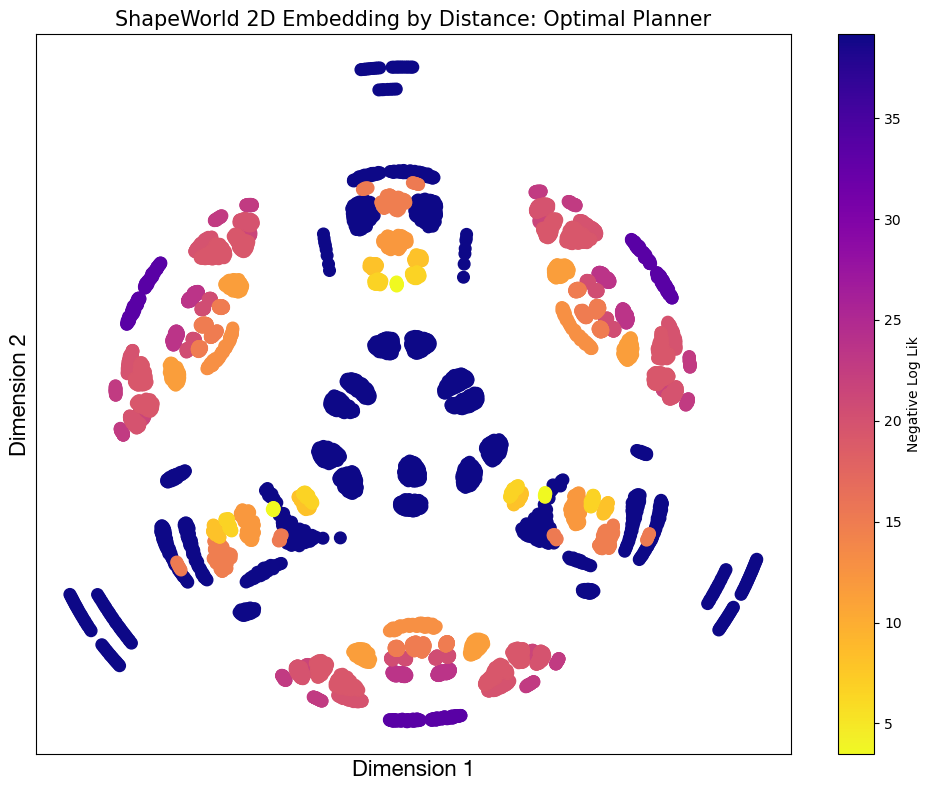

'\nif save:\n    plt.savefig(filename)\n'

In [76]:

# Check to see if the mds has been calculated
if optimal_planner.mds is None:
    optimal_planner.calc_multi_dimensional_scaling()

# Calculate the negative log likelihood of each state
neg_log_likelihoods = optimal_planner.calc_neg_log_likelihood_all_df()

# Use the states as keys to add the negative log likelihoods to the MDS dataframe
mds_df = optimal_planner.mds
mds_df['negloglik'] = mds_df['state'].map(neg_log_likelihoods.set_index('State')['Negative Log Lik'])

# Sort the DataFrame by 'negloglik' to ensure points with greater likelihoods are plotted on top
mds_df_sorted = mds_df.sort_values(by='negloglik', ascending=False)

# Calculate ranks based on 'negloglik' values. Higher values will have higher ranks.
mds_df_sorted['negloglik_rank'] = mds_df_sorted['negloglik'].rank()

# Set the font properties
font_path = os.path.abspath('/System/Library/Fonts/HelveticaNeue.ttc')  # Replace with the path to your desired font file
font_prop = fm.FontProperties(fname=font_path, size=14)

# set defult style
matplotlib.rcdefaults()
plt.figure(figsize=(10, 8))

# Plot the points with greater likelihoods on top
plt.scatter(mds_df_sorted['Dimension 1'], mds_df_sorted['Dimension 2'], c=mds_df_sorted['negloglik'], cmap='plasma_r', marker='o', alpha=1, s=70)
plt.title('ShapeWorld 2D Embedding by Distance: Optimal Planner', fontsize=15)
plt.xlabel('Dimension 1', fontproperties=font_prop, fontsize=16)  # Set the font properties for x-axis label
plt.ylabel('Dimension 2', fontproperties=font_prop, fontsize=16)  # Set the font properties for y-axis label
plt.colorbar(label='Negative Log Lik')
plt.grid(False)  # Remove gridlines

plt.xticks([])  # Remove x-axis tick labels
plt.yticks([])  # Remove y-axis tick labels
plt.tight_layout()  # Adjust spacing
plt.show()
'''
if save:
    plt.savefig(filename)
'''


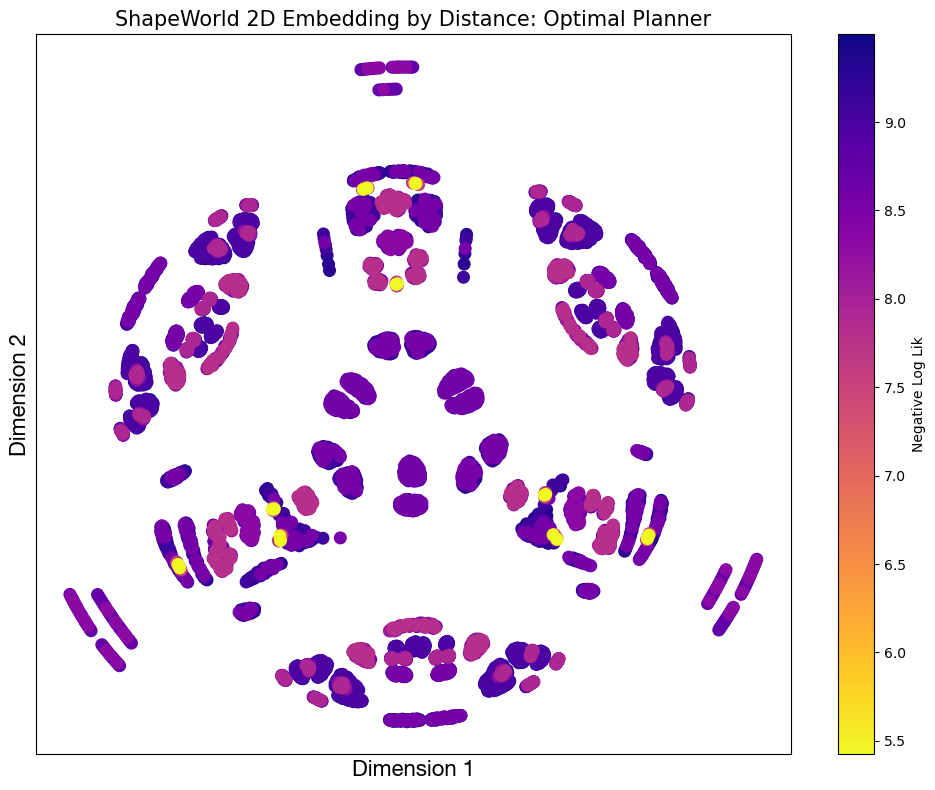

In [78]:
# Check to see if the mds has been calculated
if optimal_planner.mds is None:
    optimal_planner.calc_multi_dimensional_scaling()

# Calculate the negative log likelihood of each state
neg_log_likelihoods = pcfg_negloglik_norm

# Use the states as keys to add the negative log likelihoods to the MDS dataframe
mds_df = optimal_planner.mds
mds_df['negloglik'] = mds_df['state'].map(neg_log_likelihoods.set_index('state')['negloglik'])

# Sort the DataFrame by 'negloglik' to ensure points with greater likelihoods are plotted on top
mds_df_sorted = mds_df.sort_values(by='negloglik', ascending=False)

# Set the font properties
font_path = os.path.abspath('/System/Library/Fonts/HelveticaNeue.ttc')  # Replace with the path to your desired font file
font_prop = fm.FontProperties(fname=font_path, size=14)

# set defult style
matplotlib.rcdefaults()
plt.figure(figsize=(10, 8))

# Plot the points with greater likelihoods on top
plt.scatter(mds_df_sorted['Dimension 1'], mds_df_sorted['Dimension 2'], c=mds_df_sorted['negloglik'], cmap='plasma_r', marker='o', alpha=1, s=70)
plt.title('ShapeWorld 2D Embedding by Distance: Optimal Planner', fontsize=15)
plt.xlabel('Dimension 1', fontproperties=font_prop, fontsize=16)  # Set the font properties for x-axis label
plt.ylabel('Dimension 2', fontproperties=font_prop, fontsize=16)  # Set the font properties for y-axis label
plt.colorbar(label='Negative Log Lik')
plt.grid(False)  # Remove gridlines

plt.xticks([])  # Remove x-axis tick labels
plt.yticks([])  # Remove y-axis tick labels
plt.tight_layout()  # Adjust spacing
plt.show()

In [83]:
mds_df_sorted

,state,Dimension 1,Dimension 2,negloglik,negloglik_rank
4029,"((triangle, high, plain), (square, high, strip...",4.361613,-50.736839,9.496138,5832.0
3921,"((triangle, high, plain), (circle, high, strip...",-46.265527,24.981679,9.495897,5831.0
5397,"((triangle, medium, plain), (square, medium, s...",19.834282,-60.929351,9.495422,5830.0
248,"((circle, high, plain), (triangle, high, strip...",-45.071970,25.131282,9.495110,5829.0
4715,"((triangle, low, plain), (square, low, striped...",25.103109,-51.058699,9.494979,5828.0
...,...,...,...,...,...
1715,"((circle, medium, striped), (circle, medium, s...",-1.819117,34.551615,5.425205,5.0
3430,"((square, medium, plain), (square, medium, pla...",31.503514,-15.056220,5.423046,4.0
5488,"((triangle, medium, plain), (triangle, medium,...",-29.730574,-18.279398,5.422941,3.0
5831,"((triangle, medium, striped), (triangle, mediu...",-30.194047,-18.353733,5.422884,2.0


[9.49613817 9.49589707 9.49542243 ... 5.42294132 5.42288387 5.42285055]


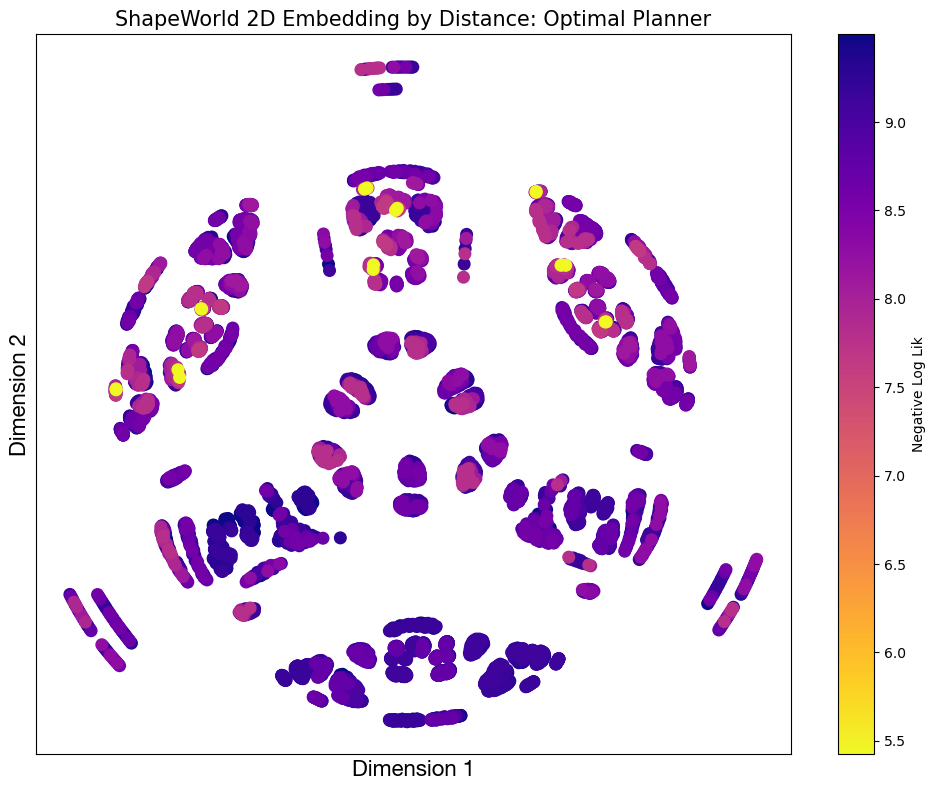

In [26]:
# Use the distance emebedding from value iteration to plot PCFG lik
optimal_planner.plot_state_space_with_other_model_likelihood_df(pcfg_negloglik_norm, 'PCFG', is_dark=False, save=True, filename='pcfg-lik-fingerprint_distanceMDS.png')

# PCFG Policy

In [5]:

class PCFGGoalPolicy(GoalSelectionPolicy[State, Action]):
    '''A policy that uses a probabilistic context-free grammar to generate goals.'''

    def __init__(self, mdp: MarkovDecisionProcess[State, Action], p_rules, cap=100):
        super().__init__(mdp)
        self.NON_TERMINALS = [x[0] for x in p_rules]
        self.PRODUCTIONS = {}
        self.CAP = cap
        self.programs = {}
        self.state_coverage = {} # the state coverage for each program
        self.program_coverage = {} # the program coverage for each state
        for rule in p_rules:
            self.PRODUCTIONS[rule[0]] = rule[1]

    def _generate_tree(self, logging=True, tree_str='S', log_prob=0., depth=0):
        '''Use the production rules to generate a possible rule.'''
        current_nt_indices = [tree_str.find(nt) for nt in self.NON_TERMINALS]
        # Sample a non-terminal for generation
        to_gen_idx = sample([idx for idx, el in enumerate(current_nt_indices) if el > -1], 1)[0]
        to_gen_nt = self.NON_TERMINALS[to_gen_idx]
        # Do generation
        leaf = sample(self.PRODUCTIONS[to_gen_nt], 1)[0]
        to_gen_tree_idx = tree_str.find(to_gen_nt)
        tree_str = tree_str[:to_gen_tree_idx] + leaf + tree_str[(to_gen_tree_idx+1):]
        # Update production log prob
        log_prob += log(1/len(self.PRODUCTIONS[to_gen_nt]))
        # Increase depth count
        depth += 1

        # Recursively rewrite string
        if any (nt in tree_str for nt in self.NON_TERMINALS) and depth <= self.CAP:
            return self._generate_tree(logging, tree_str, log_prob, depth)
        elif any (nt in tree_str for nt in self.NON_TERMINALS):
            if logging:
                print('====DEPTH EXCEEDED!====')
            return None
        else:
            if logging:
                print(tree_str, log_prob)
            return tree_str, log_prob
        
    def generate_programs(self, n_iterations=100000, ) -> pd.DataFrame:
        '''Generate a number of rules.'''
        
        # check for a saved pkl object
        if os.path.exists('pcfg_programs.pkl'):
            with open('pcfg_programs.pkl', 'rb') as file:
                print('Loading PCFG programs from pkl object...')
                programs = pickle.load(file)
                self.programs = programs
                return programs
        
        # reset rules for the object
        programs = []

        # generate rules
        for _ in range(n_iterations):
            rule = self._generate_tree(logging=False)
            if rule is not None:
                programs.append(rule)

        df = pd.DataFrame(programs, columns=['program', 'loglik'])
        grouped_df = df.groupby('program')['loglik'].mean().reset_index()
        count_df = df['program'].value_counts().reset_index()
        count_df.columns = ['program', 'count']
        result_df = pd.merge(grouped_df, count_df, on='program')
        result_df = result_df.sort_values(by='count', ascending=False).reset_index()
        self.programs = result_df

        # save this as a pkl object
        with open('pcfg_programs.pkl', 'wb') as file:
            pickle.dump(result_df, file)

        return result_df

    def extract_arguments(self,args_str):
        '''Naive argument extraction assuming balanced parentheses and simple structure'''
        level = 0
        last_split = 0
        args = []
        for i, char in enumerate(args_str):
            if char == '(':
                level += 1
            elif char == ')':
                level -= 1
            elif char == ',' and level == 0:
                args.append(args_str[last_split:i].strip())
                last_split = i + 1
        args.append(args_str[last_split:].strip())  # Add the last argument
        return args

    def one(*args, state: State) -> bool:
        '''Check the conditions for one shape in the given state based on arguments.'''
        # Remove the self argument
        args = args[1:]

        # One unique feature in the state
        if len(args) == 1 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain', 'dots']:
            feature = args[0]
            count = 0
            for shape in (state.shape1, state.shape2, state.shape3):
                if (feature in shape.sides or feature in shape.shade or feature in shape.texture):
                    count += 1
            return count == 1

        # Feature and location
        elif len(args) == 2 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain', 'dots'] and args[1] in ['(0)', '(1)', '(2)']:
            feature, location = args
            location = int(location[1])
            shape = (state.shape1, state.shape2, state.shape3)[location]
            return (feature in shape.sides or feature in shape.shade or feature in shape.texture)
        else:
            raise ValueError('Invalid number of arguments for one shape rule.')

    def two(*args, state) -> bool:
        '''Check the conditions for two shapes in the given state based on arguments.'''
        # Remove the self argument
        args = args[1:]
        # CASE 1 [two(B)]: Two of a feature anywhere
        if len(args) == 1 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain', 'dots']:
            feature = args[0]
            count = 0
            for shape in (state.shape1, state.shape2, state.shape3):
                if (feature in shape.sides or feature in shape.shade or feature in shape.texture):
                    count += 1
            return count == 2
        
        # CASE 2 [two(F,E)]: Compare two shapes for given number of features
        elif (len(args) == 2) and (args[0] in ['1','2', '3']) and args[1] in ['same', 'unique']:
            feature_count, comparison = args
            feature_count = int(feature_count)
            # Check to see if exactly two shapes share the specified number of features, and no more
            if comparison == 'same':
                matching_pairs = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 2):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    common_features = len(features1.intersection(features2))
                    # Check if the number of common features matches the specified count
                    if common_features == feature_count:
                        matching_pairs += 1
                # Return True only if exactly one pair matches the criteria
                return matching_pairs == 1
            # Check over specified number of features, if shapes are unique
            elif comparison == 'unique':
                MAX_NUM_FEATURES = 3
                non_matching_pairs = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 2):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    num_unique_features = MAX_NUM_FEATURES - len(features1.intersection(features2))
                    # Check if the number of common features exceeds the specified count
                    if num_unique_features == feature_count:
                        non_matching_pairs += 1
                # Return True only if exactly one pair matches the criteria
                return non_matching_pairs == 2
                
            else:
                return False

        # CASE 3 [two(E)]: Check to see if any two shapes are the same across all features
        elif len(args) == 1 and args[0] in ['same', 'unique']:
            comparison = args[0]
            feature_count = 3
            # Check to see if exactly two shapes share the specified number of features, and no more
            if comparison == 'same':
                matching_pairs = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 2):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    common_features = len(features1.intersection(features2))
                    # Check if the number of common features matches the specified count
                    if common_features == feature_count:
                        matching_pairs += 1
                # Return True only if exactly one pair matches the criteria
                return matching_pairs == 1
            # Check over specified number of features, if shapes are unique
            elif comparison == 'unique':
                MAX_NUM_FEATURES = 3
                non_matching_pairs = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 2):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    num_unique_features = MAX_NUM_FEATURES - len(features1.intersection(features2))
                    # Check if the number of common features exceeds the specified count
                    if num_unique_features == feature_count:
                        non_matching_pairs += 1
                # Return True only if exactly one pair matches the criteria
                return non_matching_pairs == 2
        
        # CASE 4 [two(B,D)]: Compare two locations for one feature
        elif len(args) == 2 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain', 'dots'] and args[1] in ['(0,1)', '(0,2)', '(1,2)']:
            feature, location = args
            location1 = int(location[1])
            location2 = int(location[3])
            shape1 = (state.shape1, state.shape2, state.shape3)[location1]
            shape2 = (state.shape1, state.shape2, state.shape3)[location2]
            return (feature in shape1.sides or feature in shape1.shade or feature in shape1.texture) and (feature in shape2.sides or feature in shape2.shade or feature in shape2.texture)

        # CASE 5 [two(D,E)]: Compare two locations across all features
        elif len(args) == 2 and args[0] in ['same','unique'] and args[1] in ['(0,1)', '(0,2)', '(1,2)']:
            comparison, location = args
            location1 = int(location[1])
            location2 = int(location[3])
            shape1 = (state.shape1, state.shape2, state.shape3)[location1]
            shape2 = (state.shape1, state.shape2, state.shape3)[location2]
            features1 = {shape1.sides, shape1.shade, shape1.texture}
            features2 = {shape2.sides, shape2.shade, shape2.texture}
            if comparison == 'same':
                return len(features1.intersection(features2)) == 3
            elif comparison == 'unique':
                return len(features1.intersection(features2)) == 0
            else:
                raise ValueError('Invalid call for the two shapes rule.')

        else:
            raise ValueError('Invalid call for the two shapes rule.')

    def three(*args, state: State) -> bool:
        '''Check the conditions for all shapes in the given state based on arguments.'''
        
        # Remove the self argument
        args = args[1:]

        # Feature only (assuming 'three' checks for a feature across all shapes, which is not directly specified)
        if len(args) == 1 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain', 'dots']:
            feature = args[0]
            return all(feature in shape.sides or feature in shape.shade or feature in shape.texture for shape in (state.shape1, state.shape2, state.shape3))
        
        # Compare three shapes for given number of features
        elif (len(args) == 2) and (args[0] in ['1','2','3']) and args[1] in ['same','unique']:
            feature_count, comparison = args
            feature_count = int(feature_count)
            # Check to see if all three shapes share the specified number of features, and no more
            if comparison == 'same':
                matching_triads = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 3):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    features3 = {shape_combo[2].sides, shape_combo[2].shade, shape_combo[2].texture}
                    common_features = len(features1.intersection(features2).intersection(features3))
                    # Check if the number of common features matches the specified count
                    if common_features == feature_count:
                        matching_triads += 1
                # Return True only if exactly one triad matches the criteria
                return matching_triads == 1
            
            # Check over specified number of features, if shapes are unique
            elif comparison == 'unique':
                MAX_NUM_FEATURES = 3
                non_matching_triads = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 3):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    features3 = {shape_combo[2].sides, shape_combo[2].shade, shape_combo[2].texture}
                    num_unique_features = MAX_NUM_FEATURES - len(features1.intersection(features2).intersection(features3))
                    # Check if the number of common features exceeds the specified count
                    if num_unique_features == feature_count:
                        non_matching_triads += 1
                # Return True only if exactly one triad matches the criteria
                return non_matching_triads == 1

        # TODO: Check logic here
        elif len(args) == 1 and args[0] in ['same', 'unique']:
            feature = args[0]
            features = [shape.sides for shape in (state.shape1, state.shape2, state.shape3)]
            features += [shape.shade for shape in (state.shape1, state.shape2, state.shape3)]
            features += [shape.texture for shape in (state.shape1, state.shape2, state.shape3)]
            unique_features = set(features)
            if feature == 'same':
                return len(unique_features) == 3
            elif feature == 'unique':
                return len(features) == len(unique_features)
            
        # TODO: Add case for checking multiple features

        else:
            raise ValueError('Invalid number of arguments for three shapes rule.')  

    def program_applies(self, program: str, s: State) -> bool:

        # TODO: Refactor to where program implementation do not need to be in class. Maybe a dictionary?

        # recursively unpack nested and statements
        if program.startswith('and'):
            #print(program[4:-1])
            args = self.extract_arguments(program[4:-1])
            # print(f'All arguments: {args}')
            outcome1 = self.program_applies(args[0],s)
            outcome2 = self.program_applies(args[1],s)
            return outcome1 and outcome2  #all(rule_applies(arg, s) for arg in args)
        
        # once the and statements are unpacked, we can evaluate the rules
        elif program.startswith(('one', 'two', 'three')):
            func_name, args_str = program.split('(', 1)
            args = self.extract_arguments(args_str[:-1])  # Remove the closing parenthesis and extract arguments
            func = getattr(self, func_name)  # Dynamically get the method from the class instance
            # print(f'Function: {func_name}, Arguments: {args}')
            return func(*args, state=s)  # Call the method with arguments and state
    
    def calc_program_coverage(self, state_space: Sequence[State], load=False) -> dict[str, Sequence[State]]:
        '''Calculate states covered by each program.'''
        # TODO: Vectorize this function

        # Check to see if program coverage has already been calculated and saved as a file
        if os.path.exists('pcfg_program_coverage.pkl') and load:
            print('Loading PCFG program coverage from pkl object...')
            with open('pcfg_program_coverage.pkl', 'rb') as file:
                program_coverage = pickle.load(file)
            self.program_coverage = program_coverage
            return program_coverage

        # Initialize an empty dictionary to store the states covered by each program
        program_coverage = {}
        # Loop through each program and calculate the states covered
        for program in tqdm(self.programs['program'], desc='Calculating program coverage'):
            covered_states = []
            for state in state_space:
                # print(f'Program: {program}, State: {state}')
                if self.program_applies(program, state):
                    covered_states.append(state)
            program_coverage[program] = covered_states
        self.program_coverage = program_coverage

        # save the state coverage
        with open('pcfg_program_coverage.pkl', 'wb') as file:
            pickle.dump(program_coverage, file)

        return program_coverage
    
    def _program_applies_helper(self,args) -> State:
        '''Wrapper for parallelization.'''
        program, state, program_applies_func = args
        return state if self.program_applies(program, state) else None

    def calc_program_coverage_parallel(self, state_space: Sequence[State], load=False) -> dict[str, Sequence[State]]:
        '''Calculate states covered by each program in parallel.'''
        # TODO: Troubleshoot this function
        raise NotImplementedError
        # Check to see if program coverage has already been calculated and saved as a file
        if os.path.exists('pcfg_program_coverage.pkl') and load:
            print('Loading PCFG program coverage from pkl object...')
            with open('pcfg_program_coverage.pkl', 'rb') as file:
                program_coverage = pickle.load(file)
            self.program_coverage = program_coverage
            return program_coverage

        program_coverage = {}
        # Prepare arguments for parallel processing
        tasks = [(program, state, self.program_applies) for program in self.programs['program'] for state in state_space]

        # Use ProcessPoolExecutor to parallelize the task
        with ProcessPoolExecutor() as executor:
            future_to_state = {executor.submit(self._program_applies_helper, task): task for task in tasks}
            for future in tqdm(concurrent.futures.as_completed(future_to_state), total=len(tasks), desc='Calculating program coverage'):
                program, state, _ = future_to_state[future]
                result = future.result()
                if result:
                    if program not in program_coverage:
                        program_coverage[program] = []
                    program_coverage[program].append(result)

        # Save the state coverage
        with open('pcfg_program_coverage.pkl', 'wb') as file:
            pickle.dump(program_coverage, file)

        self.program_coverage = program_coverage
        return program_coverage
    
    def calc_state_coverage(self, state_space: Sequence[State], load=False) -> dict[State, Sequence[str]]:
        # TODO: Speed up/vectorize this function
        '''Use the table produced by `calc_program_coverage()` to get the state coverage.'''

        # Check to see if state coverage has already been calculated and saved as a file
        if os.path.exists('pcfg_state_coverage.pkl') and load:
            print('Loading PCFG state coverage from pkl object...')
            with open('pcfg_state_coverage.pkl', 'rb') as file:
                state_coverage = pickle.load(file)
            self.state_coverage = state_coverage
            return state_coverage
        
        # Check to see if program coverage has already been calculated and saved as a file
        if os.path.exists('pcfg_program_coverage.pkl'):
            with open('pcfg_program_coverage.pkl', 'rb') as file:
                program_coverage = pickle.load(file)
            self.program_coverage = program_coverage
        else:
            self.calc_program_coverage(state_space, load=True)

        # Initialize an empty dictionary to store the programs covering each state
        state_coverage = {}
        # Loop through each state and calculate the programs covering it
        for state in tqdm(state_space, desc='Calculating state coverage'):
            covered_programs = []
            for program, covered_states in self.program_coverage.items():
                if state in covered_states:
                    covered_programs.append(program)
            state_coverage[state] = covered_programs
        self.state_coverage = state_coverage

        # save the program coverage
        with open('pcfg_state_coverage.pkl', 'wb') as file:
            pickle.dump(state_coverage, file)

        return state_coverage

    def loglik_state_given_program(self, program: str, state: State) -> float:
        '''Calculate the log likelihood of a state given a program.'''
        # TODO: Speed up/vectorize this function
        num_covered_states = len(self.program_coverage[program])
        if num_covered_states == 0:
            return -np.inf
        else:
            # calculate the likelihood, assuming all states are equally likely if covered
            likelihood = 1 / num_covered_states
            return np.log(likelihood)
        
    def _logsumexp(self, log_likelihoods: Sequence[float]) -> float:
        '''Calculate the log of the sum of exponentials of the log likelihoods.'''
        max_log_likelihood = max(log_likelihoods)
        # vectorized version of logsumexp
        loglik = max_log_likelihood + np.log(np.sum(np.exp(log_likelihoods - max_log_likelihood)))
        return loglik

    def calc_neg_log_likelihood_state(self, state: State) -> float:
        '''Calculate the negative log likelihood of a state given the grammar.'''
        # Initialize a list to store all log likelihoods for marginalization over programs
        log_likelihoods = []

        # Only loop through only the programs that cover the state
        programs = self.state_coverage[state]
        for program in programs:
            # print(f'Program: {program}')
            # print(f'State: {state}')
            # get the likelihood of the program given the grammar
            loglikelihood_program = self.programs[self.programs['program'] == program]['loglik'].values[0]

            # get the likelihood of the state given the program
            lik_state_given_program = self.loglik_state_given_program(program, state)

            if lik_state_given_program != -np.inf:
                # Add the product (in log space, this becomes a sum) of the log likelihoods
                log_likelihoods.append(loglikelihood_program + lik_state_given_program)
            elif loglikelihood_program == -np.inf:
                raise ValueError('Likelihood = -inf. State possibly not covered by any program.')
            else:
                raise ValueError('Unhandled case in likelihood calculation.')

        # Use logsumexp to safely compute the log of the sum of exponentials of the log likelihoods
        if log_likelihoods:  # Ensure the list is not empty to avoid logsumexp error
            total_negloglik = -self._logsumexp(log_likelihoods)
        else:
            raise ValueError('No log likelihoods to calculate. State possibly not covered by any program.')
        return total_negloglik

    def calculate_neg_log_likelihood_all_df(self) -> pd.DataFrame:
        '''Calculate the log likelihood of all states given produced rules.'''
        # check to make sure we have rules
        if len(self.programs) == 0:
            print("Generating programs...")
            self.generate_programs()
        
        # Make sure we calculate the coverage
        if len(self.program_coverage) == 0:
            print("Calculating/loading program coverage...")
            self.calc_program_coverage(self.state_space)

        if len(self.state_coverage) == 0:
            print("Calculating/loading state coverage...")
            self.calc_state_coverage(self.state_space)
        
        # iterate through all states and calculate the log likelihood
        neg_log_likelihoods = {}

        # loop through each state and rule
        for state in tqdm(self.state_space, desc='Calculating neg log likelihoods'):
            neg_log_likelihoods[state] = self.calc_neg_log_likelihood_state(state)

        # return as list of tuples for making into a data frame
        data = list(neg_log_likelihoods.items())
        state_negloglik_df = pd.DataFrame(data, columns=['state', 'negloglik']).sort_values(by='negloglik').reset_index(drop=True)  

        # Normalize the likelihoods
        pcfg_negloglik_norm = state_negloglik_df.copy()
        pcfg_negloglik_norm['lik_temp'] = np.exp(-pcfg_negloglik_norm['negloglik'])
        sum_negloglik = pcfg_negloglik_norm['lik_temp'].sum()
        pcfg_negloglik_norm['lik_temp'] = pcfg_negloglik_norm['lik_temp'] / sum_negloglik
        assert np.isclose(pcfg_negloglik_norm['lik_temp'].sum(), 1), "Likelihoods do not sum to 1."
        pcfg_negloglik_norm['negloglik'] = -np.log(pcfg_negloglik_norm['lik_temp'])
        pcfg_negloglik_norm.drop(columns=['lik_temp'], inplace=True)
        pcfg_negloglik_norm.to_csv('pcfg_negloglik.csv', index=False)
        pcfg_negloglik_norm

        # return the negative log likelihood across all states
        return pcfg_negloglik_norm

    def _get_programs(self) -> dict[str, list[str]]:
        return self.programs
    
    def _get_programs_df(self) -> pd.DataFrame:
        # put the rules in a dataframe
        df = pd.DataFrame(self.programs, columns=['program', 'lp'])
        grouped_df = df.groupby('program')['lp'].mean().reset_index()
        count_df = df['program'].value_counts().reset_index()
        count_df.columns = ['program', 'count']
        result_df = pd.merge(grouped_df, count_df, on='program')
        result_df = result_df.sort_values(by='lp', ascending=False).reset_index()
        return result_df

# An alternative PCFG

In [57]:
def _generate_tree(self, logging=True, tree_str='S', log_prob=0., depth=0):
      '''Use the production rules to generate a possible rule.'''
      current_nt_indices = [tree_str.find(nt) for nt in self.NON_TERMINALS]
      # Sample a non-terminal for generation
      to_gen_idx = sample([idx for idx, el in enumerate(current_nt_indices) if el > -1], 1)[0]
      to_gen_nt = self.NON_TERMINALS[to_gen_idx]
      # Do generation
      leaf = sample(self.PRODUCTIONS[to_gen_nt], 1)[0]
      to_gen_tree_idx = tree_str.find(to_gen_nt)
      tree_str = tree_str[:to_gen_tree_idx] + leaf + tree_str[(to_gen_tree_idx+1):]
      # Update production log prob
      log_prob += log(1/len(self.PRODUCTIONS[to_gen_nt]))
      # Increase depth count
      depth += 1

      # Recursively rewrite string
      if any (nt in tree_str for nt in self.NON_TERMINALS) and depth <= self.CAP:
          return self._generate_tree(logging, tree_str, log_prob, depth)
      elif any (nt in tree_str for nt in self.NON_TERMINALS):
          if logging:
              print('====DEPTH EXCEEDED!====')
          return None
      else:
          if logging:
              print(tree_str, log_prob)
          return tree_str, log_prob
      
def _generate_programs(self, n_iterations=100000, ) -> pd.DataFrame:
    '''Generate a number of rules.'''
    
    # check for a saved pkl object
    if os.path.exists('pcfg_programs.pkl'):
        with open('pcfg_programs.pkl', 'rb') as file:
            print('Loading PCFG programs from pkl object...')
            programs = pickle.load(file)
            self.programs = programs
            return programs
    
    # reset rules for the object
    programs = []

    # generate rules
    for _ in range(n_iterations):
        rule = self._generate_tree(logging=False)
        if rule is not None:
            programs.append(rule)

    df = pd.DataFrame(programs, columns=['program', 'loglik'])
    grouped_df = df.groupby('program')['loglik'].mean().reset_index()
    count_df = df['program'].value_counts().reset_index()
    count_df.columns = ['program', 'count']
    result_df = pd.merge(grouped_df, count_df, on='program')
    result_df = result_df.sort_values(by='count', ascending=False).reset_index()
    self.programs = result_df

    # save this as a pkl object
    with open('pcfg_programs.pkl', 'wb') as file:
        pickle.dump(result_df, file)

    return result_df

productions2 = [
  ['S', ['and(S,S)', 'A']], # allow conjunctions
  ['A', ['one(B)', 'two(B)', 'three(B)', # location symmetry, fix one feature (location agnostic, compare feature)
         'two(E)', 'three(E)', # location symetry, feature symmetry (location agnostic, feature agnostic)
         'two(F,E)', 'three(F,E)', # location symmetry, multiple feature symetry (location agnostic, feature agnostic)
         'one(B,C)', 'two(B,D)', # feature in location, specify feature (location given, feature compare)
         'two(E,D)'# give location, feature symmetry (location given, feature agnostic)
         ]],
  ['B', ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain']], # features
  ['C', ['(0)', '(1)', '(2)']], # locations
  ['D', ['(0,1)', '(0,2)', '(1,2)']], # diad locations
  ['E', ['same','unique']], # relation,
  ['F', ['1','2','3']], # number of features to compare
]

# Convert grammar to a dictionary
def convert_grammar(productions):
    return {prod[0]: prod[1] for prod in productions}

# Make a function to systematically generate all programs to a certain depth
def generate_programs(symbol, grammar, depth):
    '''Generate all possible programs to a certain depth using a PCFG.'''

    # Base case: if the symbol is terminal or depth count has reached 0
    if symbol not in grammar or depth == 0:
        return [symbol] if symbol not in grammar else grammar[symbol]

    # Recursive case: generate all possible programs at this current depth
    programs = []
    for rule in grammar[symbol]:
        # Generate programs for each non-terminal in the rule
        
def main(productions, depth):
    grammar = convert_grammar(productions)
    start_symbol = 'S'
    all_programs = generate_programs(start_symbol, grammar, depth)
    return all_programs

generate_all_programs(productions2, 3)
    


IndentationError: expected an indented block after 'for' statement on line 92 (2511403480.py, line 99)

In [6]:
# let's try a different grammar
'''
With this grammar, we cover all cases of 1,2, and 3 shapes being compared. 

But importantly, we formalize location and feature symmetry.
Location symmetry arises because the transition function between features is location agnostic.
That is, two(feature) is agnostic to the locations of the features.
Feature symmetry arises because relations between locations are feature agnostic.
That is, same(a,b) can be applied to all features. 
Thus, if people are reusing transition knowledge we might expect them to set goals using location symmetry.
If people are reusing program formulations, we might expect them to set goals using feature symmetry.
'''
productions2 = [
  ['S', ['and(S,S)', 'A']], # allow conjunctions
  ['A', ['one(B)', 'two(B)', 'three(B)', # location symmetry, fix one feature (location agnostic, compare feature)
         'two(E)', 'three(E)', # location symetry, feature symmetry (location agnostic, feature agnostic)
         'two(F,E)', 'three(F,E)', # location symmetry, multiple feature symetry (location agnostic, feature agnostic)
         'one(B,C)', 'two(B,D)', # feature in location, specify feature (location given, feature compare)
         'two(E,D)'# give location, feature symmetry (location given, feature agnostic)
         ]],
  ['B', ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain']], # features
  ['C', ['(0)', '(1)', '(2)']], # locations
  ['D', ['(0,1)', '(0,2)', '(1,2)']], # diad locations
  ['E', ['same','unique']], # relation,
  ['F', ['1','2','3']], # number of features to compare
]

# Instantiate PCFG policy
goal_world_pcfg = GoalWorld()
pcfg_policy = PCFGGoalPolicy(mdp=goal_world_pcfg, p_rules=productions2, cap=100)

# Generate or Retrieve Programs From File
pcfg_programs = pcfg_policy.generate_programs(100000)

# Prepare tables for likelihood calculation
#pcfg_program_coverage = pcfg_policy.calc_program_coverage(goal_world_pcfg.get_state_space()) # TODO: remove need for state space arg
#pcfg_state_coverage = pcfg_policy.calc_state_coverage(goal_world_pcfg.get_state_space()) # TODO: remove need for state space arg

# Intensive Log Lik Calc
#pcfg_negloglik_df = pcfg_policy.calculate_neg_log_likelihood_all_df()


Loading PCFG programs from pkl object...


In [7]:
# abbrev_programs = pcfg_policy.programs[0:500]
#pcfg_policy.programs = abbrev_programs
# Front the coverage calculation to save on computations later
prog_cov = pcfg_policy.calc_program_coverage(goal_world_pcfg.get_state_space())
state_cov = pcfg_policy.calc_state_coverage(goal_world_pcfg.get_state_space())

# Calculate the negative log likelihood of all states (this will take a while)
pcfg_negloglik = pcfg_policy.calculate_neg_log_likelihood_all_df() 

# Save the resulting data frame
pcfg_negloglik.to_csv('pcfg_negloglik.csv', index=False)



Calculating neg log likelihoods: 100%|██████████| 5832/5832 [28:23<00:00,  3.42it/s]


In [13]:
# Normalize the likelihoods
pcfg_negloglik_norm = pcfg_negloglik.copy()
pcfg_negloglik_norm['lik_temp'] = np.exp(-pcfg_negloglik_norm['negloglik'])
sum_negloglik = pcfg_negloglik_norm['lik_temp'].sum()
pcfg_negloglik_norm['lik_temp'] = pcfg_negloglik_norm['lik_temp'] / sum_negloglik
assert np.isclose(pcfg_negloglik_norm['lik_temp'].sum(), 1), "Likelihoods do not sum to 1."
pcfg_negloglik_norm['negloglik'] = -np.log(pcfg_negloglik_norm['lik_temp'])
pcfg_negloglik_norm.drop(columns=['lik_temp'], inplace=True)
pcfg_negloglik_norm.to_csv('pcfg_negloglik.csv', index=False)
pcfg_negloglik_norm



,state,negloglik
0,"((square, medium, striped), (square, medium, s...",5.422851
1,"((triangle, medium, striped), (triangle, mediu...",5.422884
2,"((triangle, medium, plain), (triangle, medium,...",5.422941
3,"((square, medium, plain), (square, medium, pla...",5.423046
4,"((circle, medium, striped), (circle, medium, s...",5.425205
...,...,...
5827,"((triangle, low, plain), (square, low, striped...",9.494979
5828,"((circle, high, plain), (triangle, high, strip...",9.495110
5829,"((triangle, medium, plain), (square, medium, s...",9.495422
5830,"((triangle, high, plain), (circle, high, strip...",9.495897


In [78]:
program = 'and(one(striped,(1)),and(two(low,(0,2)),two(same,(0,1))))'
loglik_program = pcfg_policy.programs[pcfg_policy.programs['program'] == program]
# This should not be empty!!
loglik_program

,index,program,loglik,count


In [79]:
pcfg_policy.programs

,index,program,loglik,count
0,30490,two(same),-3.688879,2508
1,30506,two(unique),-3.688879,2499
2,30459,three(same),-3.688879,2478
3,30463,three(unique),-3.688879,2474
4,30491,"two(same,(0,1))",-4.787492,885
...,...,...,...,...
30505,10165,"and(and(three(same),and(two(3,unique),and(thre...",-25.611435,1
30506,10164,"and(and(three(same),and(two(3,unique),and(and(...",-99.161198,1
30507,10163,"and(and(three(same),and(two(3,unique),and(and(...",-61.032291,1
30508,10162,"and(and(three(same),and(two(3,same),two(unique...",-29.182532,1


# Tests

In [ ]:
'''Testing program_applies()'''
program = 'one(square)'
shape1 = Shape(sides='square', shade='low', texture='striped')
shape2 = Shape(sides='circle', shade='medium', texture='plain')
shape3 = Shape(sides='triangle', shade='high', texture='striped')
state = State(shape1, shape2, shape3)
try:
    assert pcfg_policy.program_applies(program, state) == True
except AssertionError as e:
    raise AssertionError("Does contain one square: " + str(e))

program = 'two(square)'
shape1 = Shape(sides='square', shade='low', texture='striped')
shape2 = Shape(sides='circle', shade='medium', texture='plain')
shape3 = Shape(sides='triangle', shade='high', texture='striped')
state = State(shape1, shape2, shape3)
try:
    assert pcfg_policy.program_applies(program, state) == False
except AssertionError as e:
    raise AssertionError("Does contain one square: " + str(e))

program = 'two(1,same)'
shape1 = Shape(sides='square', shade='low', texture='striped')
shape2 = Shape(sides='square', shade='medium', texture='plain')
shape3 = Shape(sides='triangle', shade='high', texture='dots')
state = State(shape1, shape2, shape3)
try:
    assert pcfg_policy.program_applies(program, state) == True
except AssertionError as e:
    raise AssertionError("Does contain one square: " + str(e))

print('All tests passed!')

# Original PCFG

In [ ]:
# instantiate the goal space
goal_world_pcfg = GoalWorld()

# the rules of the grammar
productions = [
  ['S', ['and(S,S)', 'A']],
  ['A', ['same(B,C)', 'unique(B,C)']],
  ['B', ['everything', 'D', 'E']],
  ['C', ['true', 'color', 'shape', 'texture', 'false']],
  ['D', ['one', 'G']],
  ['E', ['two', 'H']],
  ['F', ['square', 'circle', 'triangle', 'light', 'medium', 'dark', 'plain', 'stripe']],
  ['G', ['a', 'b', 'c']], # location on the screen
  ['H', ['ab', 'ac', 'bc']],
]

pcfg_policy = PCFGGoalPolicy(mdp=goal_world_pcfg, p_rules=productions, cap=100)
pcfg_ll = pcfg_policy.generate_rules(100000)